### Purpose of the Notebook: 

- In this notebook I test the behaviour of the hyperstyle latents and their reliance on the hypterstyle hypernetwork offset weights for the generator
- This is to determine, whether it is possible to learn directions using the hyperstyle latents

In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
from glob import glob
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

### Load in hyperstyle generator and latents

In [3]:
os.chdir(f"{ROOT_PATH}/2_Inversion/hyperstyle")
from hyperstyle_utils import load_hyperstyle, load_generator_inputs, generate_hyperstyle
os.chdir(current_wd)

Using cpu as device


/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# Load latents
latents = np.load(f"{DATA_PATH}/Generated_Images/hyperstyle/latents.npy", allow_pickle=True).item()

In [5]:
skus = glob(f'{DATA_PATH}/Generated_Images/hyperstyle/inference_results/4/*.jpg')

# Draw two random samples from SKU list
sample = list(np.random.choice(skus, 3))
sample = [elem.split('/')[-1].split('.')[0] for elem in sample]
sample

['BA221C037-B11', 'GG721C00N-Q11', 'DI121C0G9-C11']

In [6]:
# Load in offsets
latent1, offset1 = load_generator_inputs(sample[0], latents)
latent2, offset2 = load_generator_inputs(sample[1], latents)
latent3, offset3 = load_generator_inputs(sample[2], latents)

### Generate/Load Hyperstyle outputs

In [7]:
hyp_img1 = Image.open(f'{DATA_PATH}/Generated_Images/hyperstyle/inference_results/4/{sample[0]}.jpg').convert('RGB')
hyp_img2 = Image.open(f'{DATA_PATH}/Generated_Images/hyperstyle/inference_results/4/{sample[1]}.jpg').convert('RGB')
hyp_img3 = Image.open(f'{DATA_PATH}/Generated_Images/hyperstyle/inference_results/4/{sample[2]}.jpg').convert('RGB')


In [8]:
# G_hyp = load_hyperstyle()
# gen1, hyp_img1 = generate_hyperstyle(latent1, offset1, G_hyp, return_image=True)
# gen2, hyp_img2 = generate_hyperstyle(latent2, offset2, G_hyp, return_image=True)
# gen3, hyp_img3 = generate_hyperstyle(latent3, offset3, G_hyp, return_image=True)

### Generate SG2Ada outputs from latents

In [9]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [10]:
# Load in SG2 Ada Generator
os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
# Load model architecture
experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
model_name = "network-snapshot-001200.pkl"
model_path = experiment_path + model_name
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    sg2 = architecture['G_ema']
os.chdir(current_wd)

In [11]:
# Generate images from latents using SG2Ada
sg2_img1 = sg2.synthesis(latent1.unsqueeze(0), force_fp32=True, noise_mode='const')
sg2_img1 = tensor2im(sg2_img1.squeeze(0))
sg2_img2 = sg2.synthesis(latent2.unsqueeze(0), force_fp32=True, noise_mode='const')
sg2_img2 = tensor2im(sg2_img2.squeeze(0))
sg2_img3 = sg2.synthesis(latent3.unsqueeze(0), force_fp32=True, noise_mode='const')
sg2_img3 = tensor2im(sg2_img3.squeeze(0))


### Compare outputs

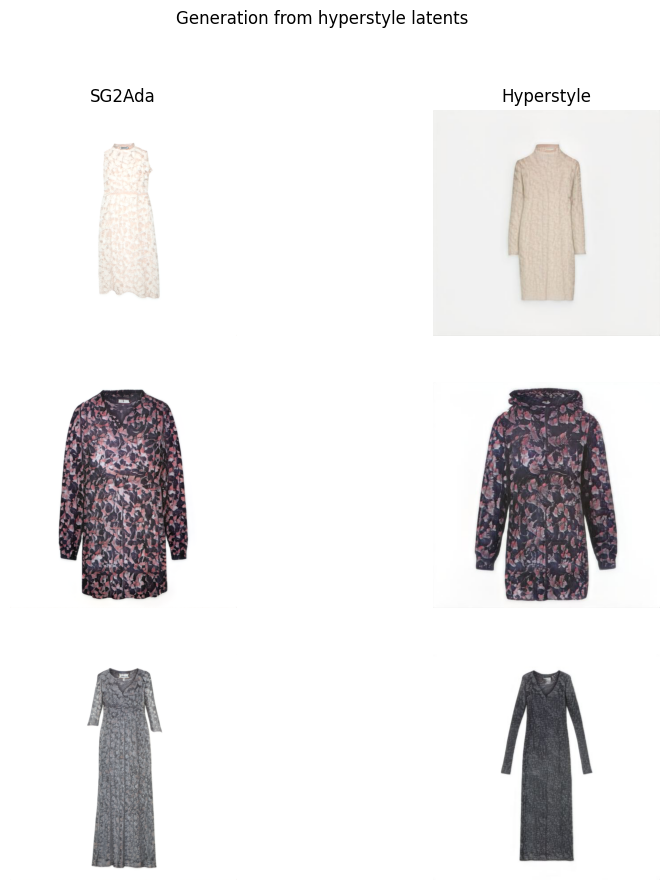

In [12]:
fig, ax = plt.subplots(3, 2, figsize = (10,10))
ax[0,0].imshow(sg2_img1)
ax[1,0].imshow(sg2_img2)
ax[2,0].imshow(sg2_img3)

ax[0,1].imshow(hyp_img1)
ax[1,1].imshow(hyp_img2)
ax[2,1].imshow(hyp_img3)

for axs in ax.flatten():
    axs.axis('off')

ax[0,0].set_title('SG2Ada')
ax[0,1].set_title('Hyperstyle')

fig.suptitle('Generation from hyperstyle latents')
plt.show()